# Simulation of direction-sensitive neurons
* This notebook contains code for simulating spike trains of direction-sensitive neurons.
* We designed our direction-sensitive neurons to have access to the spike trains V1 neurons. 
* Thus, we will simulate orientation-sensitive neurons via a function that takes the V1 spike trains as inputs. Let `f_orientation` be a function that takes as input an binary array (representing the presence of spikes of V1 neurons) and outputs the firing rate of orientation-sensitive neurons. 
* We approximate the function `f_orientation` via neural networks. 
* We then use the output of the function `f_orientation` to simulate spike trains of orientation-sensitive neurons. 

## Function `f_direction`
* input: binary vector `X` of length `n`, where `n` is the number of V1 neurons. `X[i]=1` if neuron `i` fired, and `X[i]=0` if neuron `i` did not fire. 
* output: a float vector `y` of length `m`, where `m` is the number of orientation-sensitive neurons. `y[i]` represents the firing rate of the `i`-th orientation-sensitive neuron. 

## Approximating `f_direction` via neural networks
* Ground-truth firing rates of orientation-sensitive neuron.
    * We designed orientation-sensitive neurons by specifying orientation tuning curves.
    * Orientation-tuning is often described via Gaussian-like functions, so we used unnormalized Gaussian distributions with varying center and parameters to create tuning curves.  

In [3]:
import sys
sys.path.insert(0, '../../../src')
from stimulus_helper import *
from simulations import *

from scipy.stats import lognorm, expon
import numpy as np
import pylab as pl

import h5py
import numpy as np
import joblib
import math
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from sklearn.manifold import MDS

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler

import scipy

from numpy.random import seed
seed(1)

In [4]:
directory = "../data"

# 1. Prepare data

## 1(a) Prepare input data X

In [5]:
### Training data ###
# load training stimulus orientations
file = h5py.File(directory + '/stimulus.h5','r')
train_direction = np.array(file['train_stimulus/video_directions'])
train_direction = [np.arctan2(item[0], item[1]) + math.pi - 2 * math.pi/8 for item in train_direction] #convert to angles in [0, 2 pi]
file.close()

# load V1 training raster
file = h5py.File(directory + '/V1_training_raster.h5','r')
V1_raster_train = np.array(file['raster'])
file.close()

### Simulation data ### 
# simulation stimulus orientations
file = h5py.File(directory + '/stimulus.h5','r')
simulation_direction = file['simulation_stimulus/video_directions'][:]
simulation_direction = [np.arctan2(item[0], item[1]) + math.pi - 2 * math.pi/8 for item in simulation_direction] #convert to angles in [0, 2pi]
file.close()

# load V1 simulation raster
file = h5py.File(directory + '/V1_simulation_raster.h5', 'r')
V1_raster_simulation = np.array(file['raster'])
file.close()

Create arrays `X_train`, `X_simulation`. Arrays should have shape `(n, m)`, where `n` is the number of time bins (1,000,000) and `m` is the number of V1 neurons (800)

In [6]:
X_train = V1_raster_train.transpose()
X_simulation = V1_raster_simulation.transpose()

print(X_train.shape)
print(X_simulation.shape)

(1000000, 800)
(1000000, 800)


<b> Create matrix `X`</b>
* `X` will play the role of `X_train` for `f_orientation` and `f_direction`. 
* Recall that the direction-sensitive neurons compute direction of stimulus by examining the V1 neurons' response to the previous 6 frames.
* That is, when training `f_direction`, we need the V1 neuron's response to the $i, i-1, \dots, i-5^{\text{th}}$ stimulus frames.  
* We created a matrix `X` whose $i^{\text{th}}$ row represent the V1 neurons response to the $i, i-1, \dots, i-5^{\text{th}}$ stimulus frames. 
* Let $n$ denote the number of V1 neurons.
* `X[i, 0:n]` is the V1 neurons' response to the $i^{\text{th}}$ frame
* `X[i, n:2n]` is the V1 neurons' response to the $i-1^{\text{th}}$ frame  
$$\vdots$$
* `X[i, 5n:6n]` is the V1 neuron's response to the $i-5^{\text{th}}$ frame.

<b> Example </b>
* The following example illustrates the construction of matrix `X` in a smaller scale:
    * stimulus video has 6 frames
    * V1 consists of 5 neurons
    * we want the direction neurons to look at the previous 3 frames.
* Take the response matrix $R$, make two copies of $R$, and concatenate while delaying the frame by 1 and 2.
* Let `X` denote the resulting matrix from row 3 and onwards.
* Note that the $i^{\text{th}}$ row of `X` now encodes V1 neurons' response to $i, i-1, i-2^{\text{th}}$ frames.

<img src="figures/matrixX.png" width = 800/>

In [7]:
# create X

n_videos = V1_raster_train.shape[1]
n_filters = V1_raster_train.shape[0]
X = np.zeros((n_videos, n_filters * 4))

#X[:,:n_filters] = V1_raster_train.transpose()
for idx, i in enumerate(range(0,100,25)):
    X[:,n_filters*idx:n_filters*(idx+1)] = np.roll(V1_raster_train.transpose(), i, axis=0)
    
# we remove the first few rows later, before actually training the NN


In [8]:
# create X_simulation

n_videos = V1_raster_simulation.shape[1]
n_filters = V1_raster_simulation.shape[0]
X_simulation = np.zeros((n_videos, n_filters * 4))

#X[:,:n_filters] = V1_raster_train.transpose()
for idx, i in enumerate(range(0,100,25)):
    X_simulation[:,n_filters*idx:n_filters*(idx+1)] = np.roll(V1_raster_simulation.transpose(), i, axis=0)
    

## 1(b) Create direction-sensitive neurons
* Generate the firing rate of <em>n</em> direction-sensitive neurons for each frame in training stimulus. 
* Sensitivity of each neuron is determined by the delta function. Researcher can specify the sensitivity via parameter `a`.

<b> Specify sensitivity of orientation neurons via delta function. </b>  
Given a neuron's orientation `o_neuron` and an image's orientation `o_image`, the delta function describes the neuron's firing rate as a function of `o_neuron - o_image`. The neuron will have highest firing rate when `o_neuron == o_image`, and will quickly decrease to base rate when the two orientations differ.

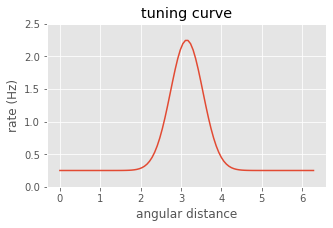

In [9]:
%matplotlib inline
theta_preferred = math.pi
R_preferred = 2
C = 0.25
sigma = 0.4

# example orientation-tuning with pi/2 as the preferred orientation
x = np.linspace(0, 2*math.pi, 100)
tc = [tuning_curve(theta_preferred, C, R_preferred, sigma, t, size = 2 * math.pi) for t in x]

fig, ax = plt.subplots(figsize = (5,3))
ax.plot(x, tc)

ax.set_title("tuning curve")
ax.set_ylabel("rate (Hz)")
ax.set_xlabel("angular distance")
ax.set_ylim((0, 2.5))
plt.show()

In [10]:
# generate direction-sensitive neurons
n_neurons = 64

# sample directions
neuron_directions = np.random.uniform(low=0, high=2 * math.pi, size=n_neurons)

# sample R_preferred
R_preferred = [2 + np.random.exponential(0) for x in range(n_neurons)]

# sample sigma
sigma = [0.4 + np.random.exponential(0) for x in range(n_neurons)]

# sample baseline rate
C = [0.25 + np.random.exponential(0) for x in range(n_neurons)]


In [11]:
# get orientation-sensitive neurons firing rate for training data
y_train = compute_firing_rates(train_direction, neuron_directions, C, R_preferred, sigma, size = 2 * math.pi)

# compute firing rates per timebin ( per 1/25 seconds)
n_bins = 25
y_train = np.repeat(y_train, n_bins, axis = 0)
print(y_train.shape)

(1000000, 64)


In [12]:
# compute rates from the true lables 

train_rates = add_noise(y_train/25, 0.05)

In [13]:
bin_size = 1
train_raster, _ = simulate_raster(train_rates, bin_size)


In [14]:
# save raster

hf = h5py.File(directory + '/direction_train_raster.h5', 'w')
hf.create_dataset('raster', data = train_raster)
hf.close()

## 3. Approximate `f_direction` via neural networks

In [15]:
# scale target variable -- this turned out to be an important step
scaler = MinMaxScaler()
scaler.fit(y_train)
y_transformed = scaler.transform(y_train)

In [16]:
# Build neural network
model = Sequential()
model.add(Dense(128,  activation = 'relu',  kernel_initializer = "he_normal"))
model.add(Dense(y_train.shape[1], activation = 'relu',  kernel_initializer = "he_normal"))

# compile
model.compile(loss='mean_squared_error', optimizer='Adam')

size is too big -- might have to sample training data

In [17]:
X.shape

(1000000, 3200)

In [ ]:
# callbacks
es = EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint(
    filepath='downstream_training/direction_checkpoint',
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

# Fit
history = model.fit(x = X, y = y_transformed, validation_split = 0.2, callbacks = [es, checkpoint], epochs = 10)


Epoch 1/10
25000/25000 [==============================] - 62s 2ms/step - loss: 0.0637 - val_loss: 0.0518
Epoch 2/10
25000/25000 [==============================] - 59s 2ms/step - loss: 0.0453 - val_loss: 0.0454
Epoch 3/10
18396/25000 [=====================>........] - ETA: 13s - loss: 0.0408

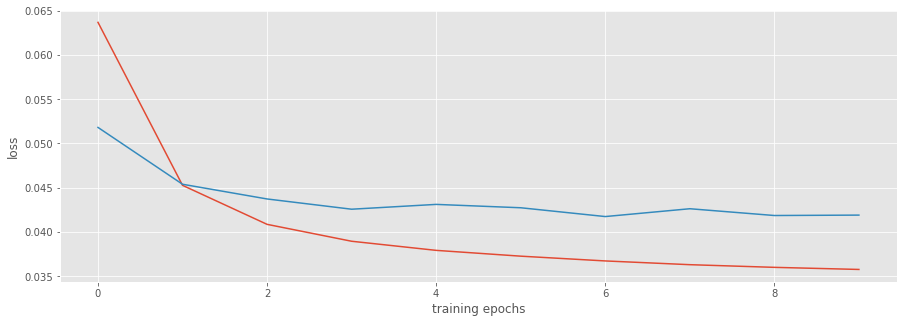

In [20]:
# plot the training and validation loss to determine if overfitting / underfitting 

# get metrics
train_loss = history.history['loss']
val_loss = history.history['val_loss']

n_epochs = len(train_loss)

fig, ax = plt.subplots(figsize = (15,5))
ax.plot(list(range(n_epochs)), train_loss, label ='train loss')
ax.plot(list(range(n_epochs)), val_loss, label ='val loss')
ax.set_xlabel('training epochs')
ax.set_ylabel('loss')

plt.show()

In [23]:
# save model
model.save(directory + '/direction_model.h5')  

# save scaler
joblib.dump(scaler, directory + "/direction_scaler.save")

['data/direction_scaler.save']

## 4. Predict firing rates of direction-sensitive neurons on simulation set

In [24]:
# get orientation-sensitive neurons firing rate for simulation data

# get orientation-sensitive neurons firing rate for training data
y_test = compute_firing_rates(simulation_direction, neuron_directions, C, R_preferred, sigma)
y_test = np.repeat(y_test, n_bins, axis = 0)

Predict firing rates

In [25]:
y_pred, score = predict_rates(X_simulation, y_test, model, scaler)

print("Scores on test (simulation) sets ")
print("score on y_test: ", score)


Scores on test (simulation) sets 
score on y_test:  0.20019002742807293


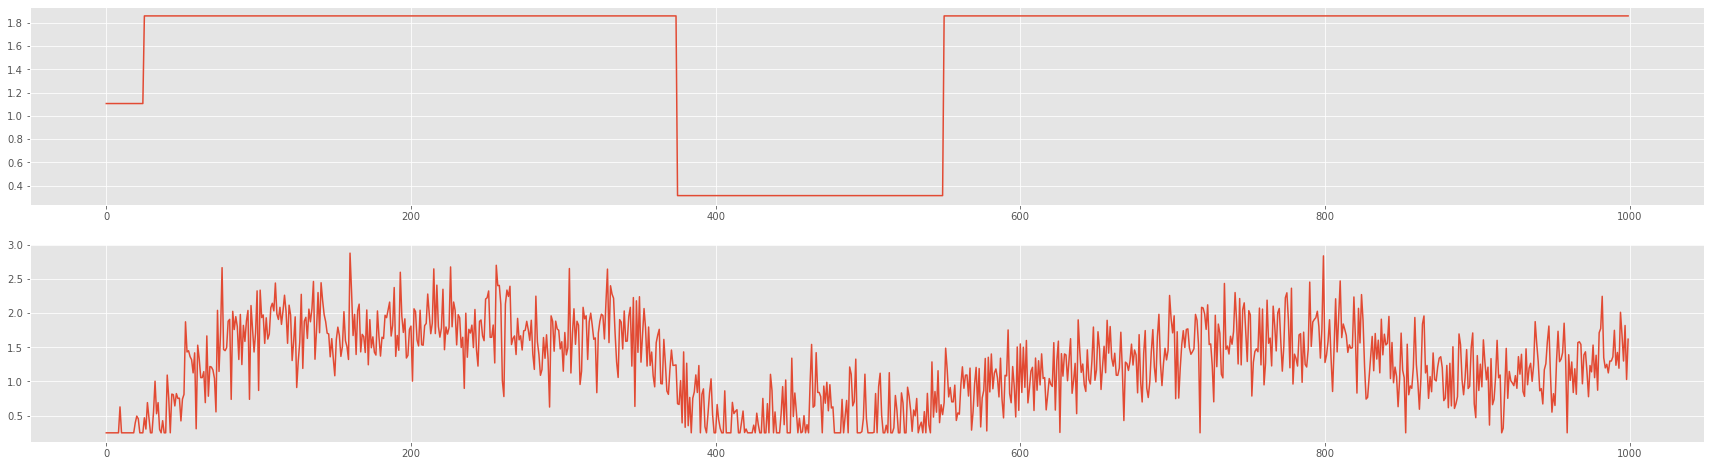

In [26]:
# plot examples of true firing rates and predicted firing rates
neuron = 0
fig, ax = plt.subplots(nrows = 2, figsize = (30, 8))
ax[0].plot(y_test[:1000, neuron])
ax[1].plot(y_pred[:1000, neuron])
plt.show()

## 5. Add noise to firing rate

$$r(\theta) = [f(\theta) + \eta]_+$$
* $f(\theta)$ : predicted firing rate
* $\eta$: Gaussian noise
* $[ \quad ]_+$: rectification of negative values to zero

In [43]:
y_new = add_unreliable_intervals(y_pred, 0.5, n_bins, 0.25)

In [44]:
# compute rates from the true lables 

rates = add_noise(y_new/25, 0.05)
#rate_pred = add_noise(y_pred/25, 0) # 0.05 seems like a good value 

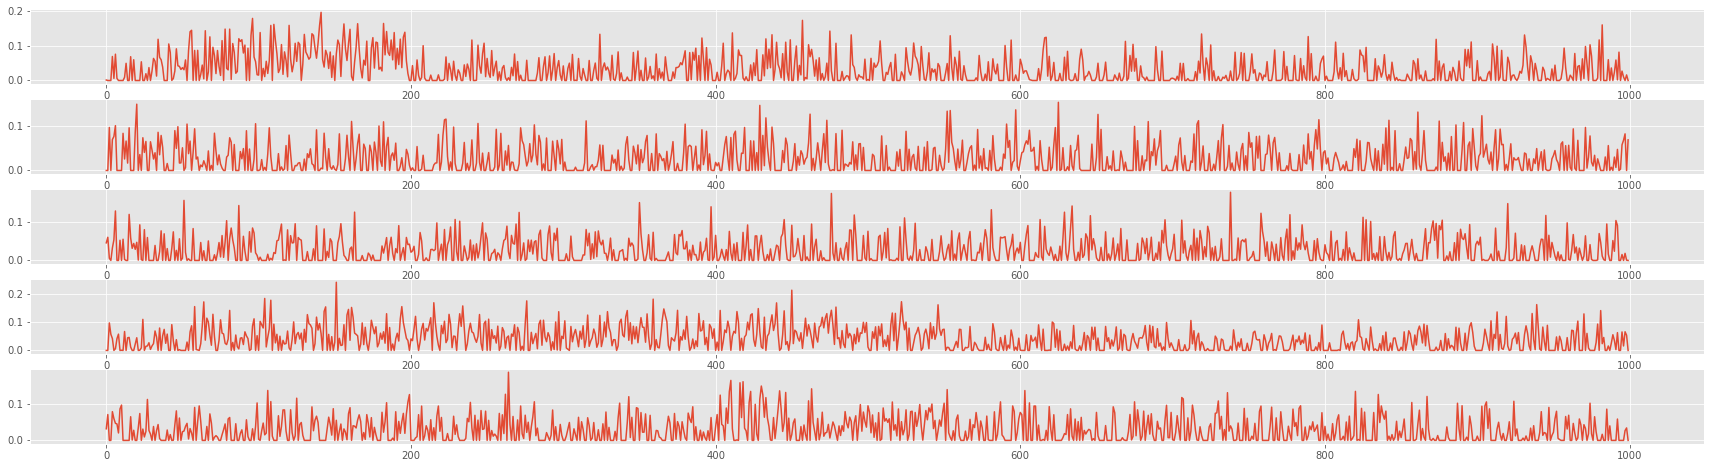

In [45]:
# select neuron #with noise
neuron = 0

fig, ax = plt.subplots(nrows = 5, figsize = (30, 8))
for i in range(5):
    ax[i].plot(rates[:1000, i])

plt.show()

## 6. Simulate raster

simulate spike trains

In [46]:
bin_size = 1
raster, _ = simulate_raster(rates, bin_size)


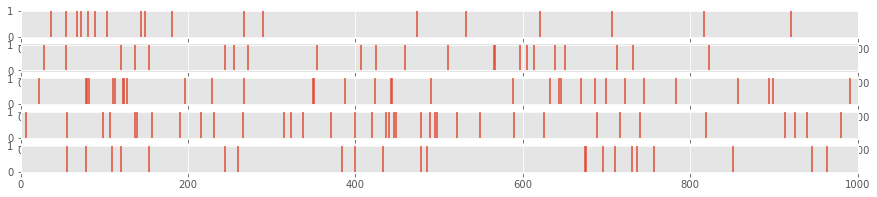

In [47]:
neuron = 0  
start = 0
end = 1000


# plot orientation neuron spike trains
fig, ax = plt.subplots(nrows = 5, figsize = (15, 3))
for i in range(5):
    plot_spike_train(raster[i,:], start, end, ax = ax[i])

plt.show()

Save raster

In [48]:
# save orientation raster

hf = h5py.File(directory + '/direction_raster.h5', 'w')
hf.create_dataset('raster', data = raster)
hf.close()